In [1]:
%load_ext autoreload
%autoreload 2
from sound_field import SoundField
from signal_info import signal_info
from optimizer import optimizer
from DoA_est import DoA_via_bands
import utils
import numpy as np
import math
import time
import torch
import gc
import os
from collections import defaultdict,Counter
import matplotlib.pyplot as plt
import dataclasses

LEBEDEV = 'lebedev'
POINTS_162 = '162_points'
SQP_OPT_METHOD = "SQP"
GD_DEEP_OPT_METHOD = "GD_Deep"
GD_OPT_METHOD = "GD_lagrange_multi" #GD_Deep GD_lagrange_multi
SLS_OPT_METHOD = "SLS"
if torch.cuda.is_available():
    DEVICE = torch.device("cuda:0")
    print("Device Name:", torch.cuda.get_device_name(DEVICE))
else:
    DEVICE = torch.device("cpu")
    print("Device Name: CPU")
torch.set_grad_enabled(False)
torch.cuda.empty_cache()  # Free up unused memory on GPU
gc.collect()  # Clean up unused memory on CPU


# Notes:
# 1) Do we really need such a high # of iter? Maybe some windows/freqs we can stop early?
# 2) Diff # of iter in localization and sound field creation?
# 3) Add mask creatiion to class? (add mask detauils to sound_field)
# 4) Sparse Attention


Device Name: NVIDIA GeForce RTX 4080 SUPER


56

In [2]:
def mem_status():
    gc.collect() 
    gpu_tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.device.type == 'cuda']
    print(f"GPU Tensors: {len(gpu_tensors)}")
    for tensor in gpu_tensors:
        num_elements = tensor.numel()
        element_size = tensor.element_size()
        memory_size_bytes = num_elements * element_size / 1e6
        print(f"Tensor on device: {tensor.device} : {memory_size_bytes}  MB")

In [3]:
mem_status()

GPU Tensors: 0


C:\Users\amitmils\AppData\Local\Temp\ipykernel_20016\3564447253.py:3: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  gpu_tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.device.type == 'cuda']


In [4]:
signals = [
    signal_info(
        name="male",
        signal_path=r"data/sound_files/male_speech.wav",
        th=90,
        ph=90,
        in_rad=False,
    ),
    signal_info(
        name="female",
        signal_path=r"data/sound_files/female_speech.wav",
        th=90,
        ph=45,
        in_rad=False,
    ),
]

### Encode Sound Field

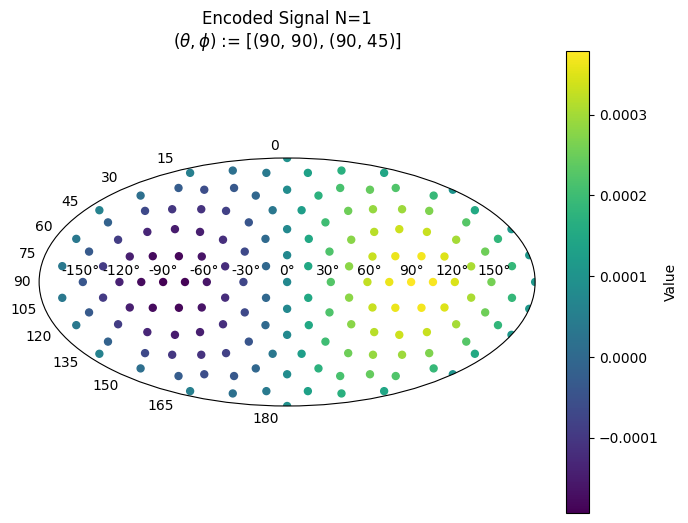

In [5]:
sound_field = SoundField(DEVICE)
input_order = 1
anm_t = sound_field.create(
    signals=signals,
    order=input_order,
    debug=True,
    grid_type=POINTS_162,
)

### Divide to Subbands

In [6]:
down_sample = 2
num_bins = 45
anm_t_subbands = sound_field.divide_to_subbands(
    num_bins=num_bins, downsample=down_sample
)
print(anm_t_subbands.shape)
print(f"{anm_t_subbands.is_cuda=}")

torch.Size([45, 68185, 4])
anm_t_subbands.is_cuda=False


### Divide to Windows

In [7]:
window_length = 1024
max_num_windows = 30
anm_t_windowed = sound_field.divide_to_time_windows(
    window_length=window_length, max_num_windows=int(max_num_windows)
)
print(anm_t_windowed.shape)
print(f"{anm_t_windowed.is_cuda=}")

torch.Size([30, 45, 1024, 4])
anm_t_windowed.is_cuda=False


### Create Mask


In [8]:
mask_type = None # "cheat" None , 'algo'

if mask_type is None:
    mask = None
    sound_field.has_mask = False
else:
    sound_field.has_mask = True
    if mask_type == "cheat":
        target_th = torch.tensor([math.radians(coo[0]) for coo in sound_field.sources_coords])
        target_ph = torch.tensor([math.radians(coo[1]) for coo in sound_field.sources_coords])
        mask = torch.any(torch.sqrt((sound_field.P_th[...,None] - target_th)**2 + (sound_field.P_ph[...,None] - target_ph)**2) < math.radians(5),dim=1)
    elif mask_type == "algo":
        pass
    dummy = torch.zeros_like(mask)
    dummy[mask] = 1
    utils.plot_on_2D(
        azi=sound_field.P_ph,
        zen=sound_field.P_th,
        values=dummy,
        title=f"Spatial Mask\n$(\\theta,\\phi)$ := {[tuple((round(th),round(phi))) for (th,phi) in sound_field.sources_coords]}",
    )


### Find Sparse Dict


100%|██████████| 100000/100000 [01:01<00:00, 1631.58it/s]


Finished Optimization...Unmixing
Finished Unmixing...
Sound field saved to data/output\sound_field_1_order_30_win_45_bin_162_points_NOmask_24Y_12M_29F_22H_13m.pt
Time: 63.478736877441406


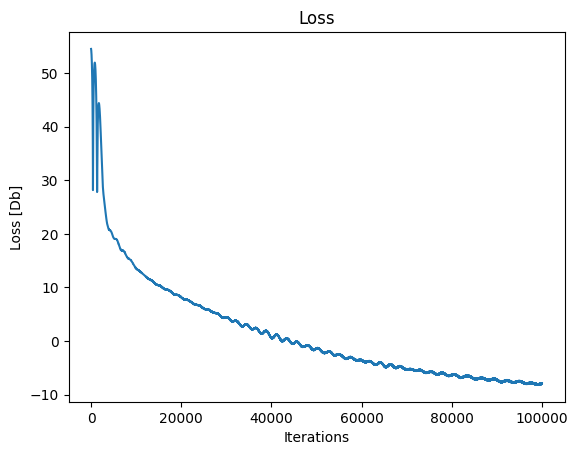

In [35]:
if True:
    Y_p = utils.create_sh_matrix(input_order, zen=sound_field.P_th, azi=sound_field.P_ph).to(DEVICE)
    opt = optimizer(Y_p, alpha=0.5, method=GD_OPT_METHOD,device=DEVICE)
    start = time.time()
    with torch.no_grad():
        anm_t_subbands_dict = sound_field.get_sparse_dict_v2(opt,mask,iter = 1e5,multi_processing=False,save=True) #single processing progress bar doesnt work
    print(f"Time: {time.time()-start}")

In [36]:
GD_old = opt.reconstruction_loss

In [18]:
GD_lambda_0 = opt.reconstruction_loss

In [20]:
GD_lambda_dot01 = opt.reconstruction_loss

In [25]:
GD_lambda_dot1 = opt.reconstruction_loss

In [27]:
GD_lambda_dot2 = opt.reconstruction_loss

In [29]:

GD_lambda_dot5 = opt.reconstruction_loss

<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:2: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
C:\Users\amitmils\AppData\Local\Temp\ipykernel_20016\162613574.py:2: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(GD_lambda_0,label="$\lambda$ = 0")
C:\Users\amitmils\AppData\Local\Temp\ipykernel_20016\162613574.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(GD_lambda_dot01,label="$\lambda$ = 0.01")
C:\Users\amitmils\AppData\Local\Temp\ipykernel_20016\162613574.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.plot(GD_lambda_dot1,label="$\lambda$ = 0.1")
C:\Users\am

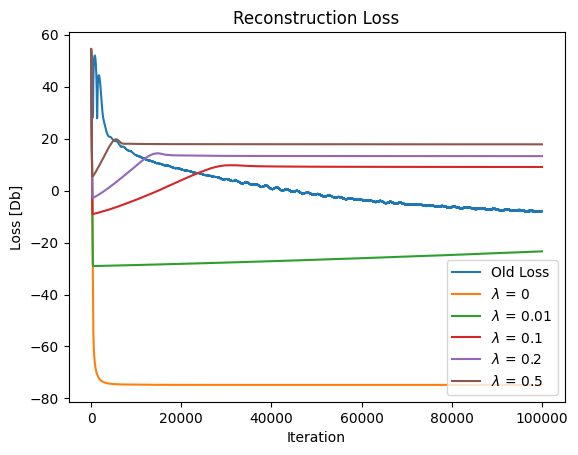

In [37]:
plt.plot(GD_old,label="Old Loss")
plt.plot(GD_lambda_0,label="$\lambda$ = 0")
plt.plot(GD_lambda_dot01,label="$\lambda$ = 0.01")
plt.plot(GD_lambda_dot1,label="$\lambda$ = 0.1")
plt.plot(GD_lambda_dot2,label="$\lambda$ = 0.2")
plt.plot(GD_lambda_dot5,label="$\lambda$ = 0.5")
plt.title("Reconstruction Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss [Db]")
plt.legend()

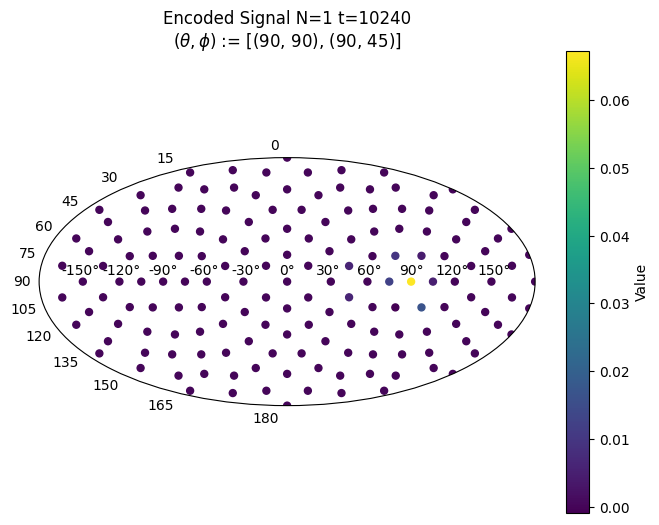

In [14]:
sound_field.plot_sparse_dict(10*1024)

In [2]:
sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_2702_points_NOmask_24Y_11M_21F_21H_12m.pt")

<>:1: SyntaxWarning: invalid escape sequence '\s'
<>:1: SyntaxWarning: invalid escape sequence '\s'
C:\Users\amitmils\AppData\Local\Temp\ipykernel_26636\229298355.py:1: SyntaxWarning: invalid escape sequence '\s'
  sound_field = torch.load("data/output\sound_field_1_order_30_win_45_bin_2702_points_NOmask_24Y_11M_21F_21H_12m.pt")
C:\Users\amitmils\AppData\Local\Temp\ipykernel_26636\229298355.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly all

## Direction 

In [ ]:
doa_estimator = DoA_via_bands(sound_field, DEVICE)

1/30
2/30


: 

In [ ]:
doa_estimator.normalized_abs_sound_field[10,40].shape


torch.Size([30, 2702, 1024])

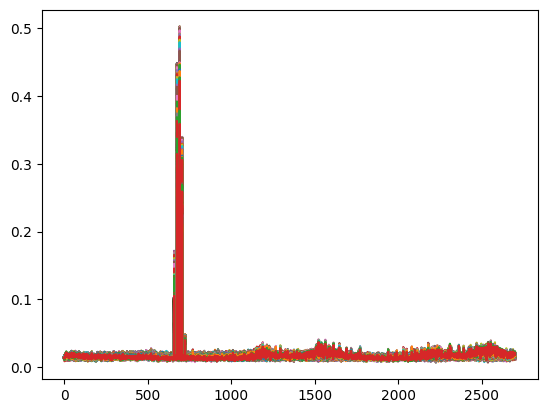

In [ ]:
doa_estimator.normalized_abs_sound_field.shape
tmp = doa_estimator.normalized_abs_sound_field.sum(dim=1)
for i in range(doa_estimator.normalized_abs_sound_field.shape[1]):
    plt.figure()
    plt.plot(doa_estimator.normalized_abs_sound_field[10,i])
    plt.title(f"Bin : {i}")
plt.show()

In [12]:
est = doa_estimator._get_window_candidates()

In [14]:
est[0]

[]

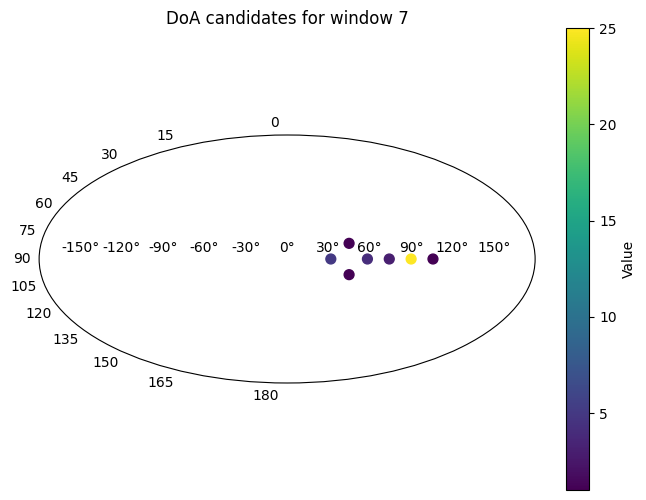

In [254]:
doa_estimator.plot_window_candidates(est,window=7)

In [102]:
def show_candidates(window_dir_candidates,window_num = None):
    if window_num is None:
        for window_num in range(len(window_dir_candidates)):
            th = window_dir_candidates[window_num][:,0].numpy()
            phi = window_dir_candidates[window_num][:,1].numpy()
            prob = window_dir_candidates[window_num][:,2].numpy()
            if len(th) == 0:
                print(f"Window {window_num} No candidates")
                continue
            plt.figure()
            plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
            plt.xlim(-180,180)
            plt.ylim(0,180)
            plt.scatter(th,phi,c=prob,cmap='viridis')
            plt.colorbar()
    else:
        plt.figure()
        plt.title(f"Window {window_num} DoA candidates\n({th@prob:.2f},{phi@prob:.2f})")
        plt.xlim(-180,180)
        plt.ylim(0,180)
        plt.scatter(th,phi,c=prob,cmap='viridis')
        plt.colorbar()

In [49]:
sound_field.play_sparse_sound_field(theta=90,phi=0,radius = 20)

torch.Size([162, 30720])
## Playing Directions ##
Theta = 0.0, Phi = 90.0
Theta = -15.450437086325833, Phi = 80.65029645742543
Theta = 0.0, Phi = 74.1412627942695
Theta = 0.0, Phi = 105.8587372057305
Theta = -15.450437086325833, Phi = 99.34970354257459
Theta = 15.450437086325833, Phi = 80.65029645742543
Theta = 15.450437086325833, Phi = 99.34970354257459
